In [1]:
import sys
sys.path.append('../')

import numpy
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
from keras.layers import SimpleRNN
from keras.models import Sequential

from b3data.utils.stock_util import  StockUtil
from b3data.utils.smote import duplicate_data
from insiders.models.densegru import DenseGRU
from insiders.models.denselstm import DenseLSTM
from validators.plotters.plotter_utils import Plotter

Using TensorFlow backend.


### Getting stock data

In [2]:
stockutil = StockUtil(['PETR3'], [9])
prices, preds = stockutil.average_prices_preds()
plotter = Plotter()

### Slice dataset in training data and test data

In [3]:
train_proportion = 0.7

train_size = int(len(prices[0]) * train_proportion)

train_x = prices[0][0:train_size]
test_x = prices[0][train_size:len(prices[0])]
train_y = preds[0][0:train_size]
test_y = preds[0][train_size:len(prices[0])]

### Testing on LSTM

1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4851/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4852/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4853/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4854/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4855/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4856/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4857/5000
134/134 - 0s - loss: 5.5254 - accuracy: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4858/5000
13

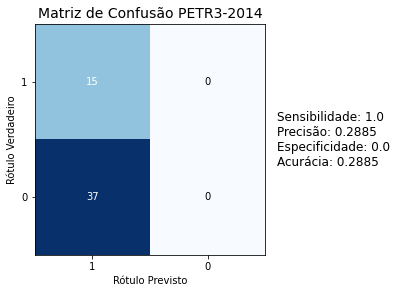

In [13]:
lstm = DenseLSTM(look_back=6, dense=False)
lstm.create_data_for_fit(numpy.array(prices[0]).reshape(len(prices[0]), 1))
result = lstm.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on KNN

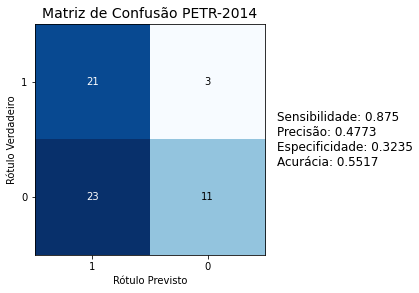

In [5]:
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = numpy.matrix(numpy.ones((an+1,bn+1)) * numpy.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = numpy.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]


X = numpy.array(train_x).reshape(len(train_x), 1)
Y = train_y

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

neigh = KNeighborsRegressor(n_neighbors=1, metric=DTW)
neigh.fit(X, Y)
X_test = numpy.array(test_x).reshape(len(test_x), 1)

X_test = scaler.fit_transform(X_test)

score = 0
y_preds = []
for i, pred in enumerate(neigh.predict(X_test)):
    if pred >= 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

plotter.plot_confusion_matrix(test_y,
                              y_preds,
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on LSTM optimized

s: 0.0845 - accuracy: 0.9552 - f1_m: 0.3284 - precision_m: 0.3284 - recall_m: 0.3284
Epoch 4836/5000
134/134 - 0s - loss: 0.1253 - accuracy: 0.9627 - f1_m: 0.3358 - precision_m: 0.3358 - recall_m: 0.3358
Epoch 4837/5000
134/134 - 0s - loss: 0.1262 - accuracy: 0.9552 - f1_m: 0.3358 - precision_m: 0.3358 - recall_m: 0.3358
Epoch 4838/5000
134/134 - 0s - loss: 0.1127 - accuracy: 0.9478 - f1_m: 0.3284 - precision_m: 0.3284 - recall_m: 0.3284
Epoch 4839/5000
134/134 - 0s - loss: 0.1333 - accuracy: 0.9552 - f1_m: 0.3358 - precision_m: 0.3358 - recall_m: 0.3358
Epoch 4840/5000
134/134 - 0s - loss: 0.1117 - accuracy: 0.9627 - f1_m: 0.3433 - precision_m: 0.3433 - recall_m: 0.3433
Epoch 4841/5000
134/134 - 0s - loss: 0.1301 - accuracy: 0.9552 - f1_m: 0.3358 - precision_m: 0.3358 - recall_m: 0.3358
Epoch 4842/5000
134/134 - 0s - loss: 0.1121 - accuracy: 0.9552 - f1_m: 0.3284 - precision_m: 0.3284 - recall_m: 0.3284
Epoch 4843/5000
134/134 - 0s - loss: 0.1174 - accuracy: 0.9478 - f1_m: 0.3358 - pr

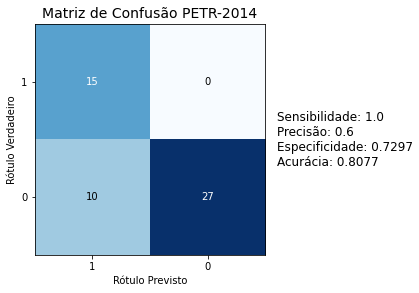

In [6]:
lstm = DenseLSTM(look_back=6, dense=1, lstm_cells=50)
lstm.create_data_for_fit(numpy.array(prices[0]).reshape(len(prices[0]), 1))
result = lstm.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on GRU

_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4845/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4846/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4847/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4848/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4849/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4850/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4851/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6418 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4852/5000
134/134 - 0s - loss: 5.5254 - acc: 0.6

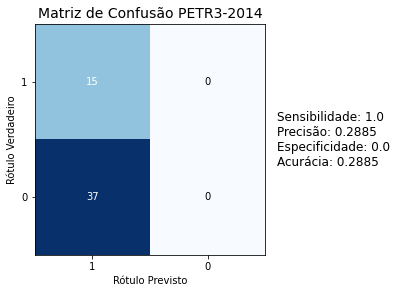

In [14]:
gru = DenseGRU(look_back=6, dense=False)
gru.create_data_for_fit(numpy.array(prices[0]).reshape(len(prices[0]), 1))
result = gru.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on SVM

... C=1, epsilon=0.01, kernel=poly, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.001, kernel=rbf ..................................
[CV] ................... C=1, epsilon=0.001, kernel=rbf, total=   0.0s
[CV] C=1, epsilon=0.001, kernel=rbf ..................................
[CV] ................... C=

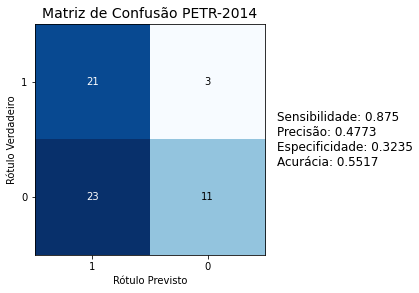

In [8]:
param_grid = {'C': [0.1,1, 10, 100], 
              'epsilon': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(X,Y)

svr = grid.best_estimator_
svr.predict(X_test)

y_preds = []
for i, pred in enumerate(neigh.predict(X_test)):
    if pred >= 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

plotter.plot_confusion_matrix(test_y,
                              y_preds,
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on RNN

2/2 [==============================] - 0s 822us/step - loss: 0.6479 - accuracy: 0.5385
accuracy: 0.5384615659713745


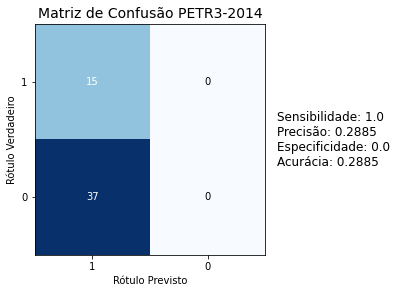

In [17]:
model = Sequential()

model.add(SimpleRNN(activation="sigmoid", units=1))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(gru.train_x, gru.train_y, epochs=5000, verbose=0)
result = model.evaluate(gru.test_x, gru.test_y)
print('accuracy: ' + str(result[1]))
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)